# Performance/Cost Assessment of EC2 Types Using Dask
## Downscale MUR SST 1 km files via an EC2 instance, accessing S3 buckets and utilizing dask parallel computing

This notebook is a first demonstration of functions and workflow. MUR 1 km files are accessed via S3, downscaled to 100 km resolution over the entire globe, and saved as .nc files in a new folder. 

Uses the MUR Level 4 daily SST ultra high resolution data product, 0.01 degree resolution:
* product information: https://doi.org/10.5067/GHGMR-4FJ04
* s3 location `s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/`.

<br>

**Requirements to run this notebook**
* Run from an AWS EC2 instance (bare minimum of t2.xlarge recommended).
* Have a URS Earthdata login, with login credentials placed in the `.netrc` file on the home directory of the instance:
```
machine urs.earthdata.nasa.gov
    login <Earthdata username>
    password <Earthdata password>
```

<br>

**Other notes**
* Seems like a minimum of a t2.xlarge instance (8 GB RAM) is required.
* ***Garbage collection and variable deletion is essential. EC2 instance runs out of RAM otherwise.***

<br>


In [1]:
import gc
import os
import shutil

import s3fs
import requests

import xarray as xr
import numpy as np
import pandas as pd

import multiprocessing
import dask.array as da
from dask import delayed
from dask.distributed import Client

import matplotlib.pyplot as plt
%matplotlib inline

## Establish S3 connection and obtain MUR file paths
**!!** If code blocks in this section fail, ensure that the requirements to run this notebook listed above have been met.

In [2]:
def init_S3FileSystem():
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it 
    to obtain a temporary AWS S3 credential through a podaac service accessable at 
    https://archive.podaac.earthdata.nasa.gov/s3credentials
    
    Return:
    =======
    s3: an AWS S3 filesystem
    """
    import requests, s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'],
                           client_kwargs={'region_name':'us-west-2'})
    return s3

In [3]:
# Get temporary AWS credentials for access
fs_s3 = init_S3FileSystem()

In [4]:
# File paths of all MUR granules:
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc")
print("total granules = ",len(fns))
print("Example filename: ", fns[0])

total granules =  7677
Example filename:  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


## Function to load and downscale MUR SST files

In [5]:
def downscale_xr_s3(fs_s3, filepath_s3, output_dir, chunks=None):
    """
    Open and downscale SST's from 1 km to 100 km from a MUR 1 km file on an 
    S3 bucket. fs_s3 is the S3 file system and filepath_s3 is the MUR 
    filepath on S3. output_dir is the directory to save the downscaled 
    data file in.
    """
    
    print('Opening ', filepath_s3)
    s3_file_obj = fs_s3.open(filepath_s3, mode='rb')
    sstdata = xr.open_dataset(s3_file_obj, chunks=chunks)
    
    def downscale_mursst(sst):
        """
        This function takes MUR SST 1km data (with dimensions of 17900x36000), reshapes, and 
        computes the mean temperature in 1x1 degree boxes, and then returns the processed 
        SST data (shape 180x360).

        Parameters
        ----------
        sst: 2D array-like of sea surface temperatures.
        """
        sst0 = np.r_[sst[0:1, :], sst]; del sst
        sst = sst0.reshape(180, 100, 360, 100).mean(axis=-1).mean(axis=1); del sst0
        return sst
    
    print("Downscaling.")
    sst_downscaled = downscale_mursst(sstdata['analysed_sst'][0, ...])
    
    # Save downscaled SST to .nc file:
    print("Saving output.")
    ds = xr.Dataset(
        data_vars=dict(
            sst=(["time", "lat", "lon"], np.expand_dims(sst_downscaled, axis=0)) # Add dim for time.
            ),
        coords=dict(
            lon=sstdata['lon'].values[::100], # lons, lats in downscaled res.
            lat=sstdata['lat'].values[::100],
            time=sstdata["time"].values,
            ),
        attrs=dict(
            description="SST downscaled from MUR 1 km file to 100 km resolution.",
            units="K",
            ),
        )
    ds.to_netcdf(output_dir + filepath_s3.split("/")[-1][:-3] + "_downscaled.nc")
    
    sstdata.close()

## Control: Downscale 10 files without Dask

Directory to save downscaled files in:

In [6]:
dir_downscaled = "./sst_downscaled/"
shutil.rmtree(dir_downscaled)
os.mkdir(dir_downscaled)

In [9]:
%%time
for i in range(10):
    downscale_xr_s3(fs_s3, fns[i], dir_downscaled)

Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv

## Test: Downscale 10 files with Dask

**Clear output folder**

In [7]:
files_rm = [f for f in os.listdir(dir_downscaled) if f.endswith(".nc")]
for f in files_rm:
    os.remove(dir_downscaled + f)

**Setup Dask cluster**

In [8]:
# Just to see, print available CPUs on this machine:
print(multiprocessing.cpu_count())

4


In [9]:
client = Client(n_workers=2, threads_per_worker=1, )
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/ec2-user/compute_tests/dask-worker-space/worker-gqa1dx3t', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/ec2-user/compute_tests/dask-worker-space/worker-3zngy3ey', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38207,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:41671,Total threads: 1
Dashboard: http://127.0.0.1:33759/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:33565,


**Parallelize downscaling function and run computation on 10 files**

The client may product memory warning messages but the computations will still complete.

In [10]:
# Wrap the process_granule function with dask.delayed
delayed_downscale = delayed(downscale_xr_s3)

In [11]:
%%time
# Process all granules in parallel using Dask
dscale_tasks = [
    delayed_downscale(fs_s3, fn, dir_downscaled) 
    for fn in fns[:10]
    ]
_ = da.compute(*dscale_tasks)

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.68 GiB -- Worker memory limit: 7.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.55 GiB -- Worker memory limit: 7.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.62 GiB -- Worker memory limit: 7.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 7.35 s, sys: 1.02 s, total: 8.37 s
Wall time: 2min 33s


In [13]:
client.close()

Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020608090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020609090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv

In [12]:
fnames_dscaled = [f for f in os.listdir("./sst_downscaled/") if "_downscaled" in f]
fnames_dscaled

['20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020608090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020609090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020610090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc']

## Test plot for one of the output files

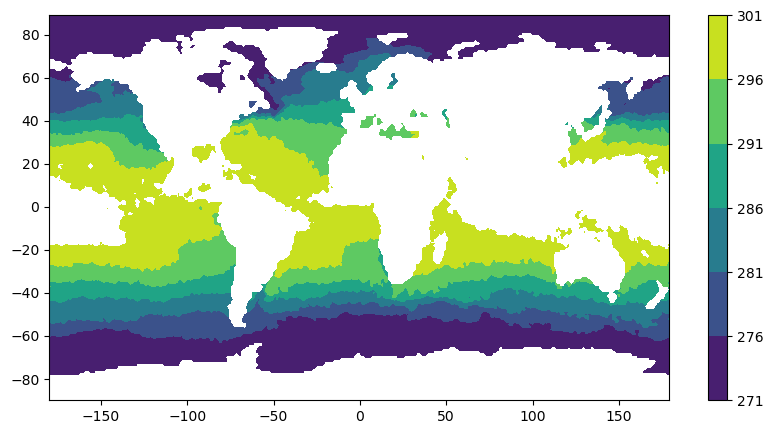

In [42]:
dscaled_test = xr.open_dataset("./sst_downscaled/" + fnames_dscaled[5])
clevs = np.arange(271, 305, 5)

fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
cp = ax.contourf(dscaled_test['lon'], dscaled_test['lat'], dscaled_test['sst'][0, ...], levels=clevs)
fig.colorbar(cp, ax=ax)

dscaled_test.close()

## Summary

About 50% decrease in computation time with 2 workers (gut check passed)

**Other notes**

On the t2.xlarge (4 vCPUs, ~16 GiB memory)
* having 4 workers with 4 threads fails, 
* having 2 workers with 4 threads succeeds but takes the same amount of time as sequential computation, 